# Mentoria de IA - Recuperação da Informação

__Aluno:__ Victor de Sousa Rocha

__Mentor:__ Eduardo Montesuma

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spacy
import spacy.cli

spacy.cli.download('pt_core_news_sm')

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
!pip install unidecode

     |████████████████████████████████| 235 kB 5.2 MB/s 


In [ ]:
import os
import re
import nltk
import spacy
import string
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


nlp = spacy.load("pt_core_news_sm")
tokenizer = nlp.tokenizer
path = '/content/drive/MyDrive/mentoria/datasets/'

In [ ]:
df = pd.read_csv(os.path.join(path, 'DAL_Corpus.csv'), sep=';')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df

,id,text,curso,aula
0,introducao_a_python-aula1.2-aba1.html,"Olá, seja bem-vindo(a). Neste curso, você vai...",introducao_a_python,aula1.2
1,ingles_a2_v2-aula06-aba3.html,TOPIC 2 - When are we going to take a tour in...,ingles_a2_v2,aula06
2,fundamentos_de_programacao_para_a_web_com_java...,TÓPICO 2 –Criando o primeiro projeto web Obj...,fundamentos_de_programacao_para_a_web_com_java,aula01
3,fundamentos_de_programacao_orientada_a_objetos...,Tópico 1 – O que são Classes Abstratas. Obje...,fundamentos_de_programacao_orientada_a_objetos...,aula6
4,planejamento_e_desenvolvimento_de_aplicacoes_a...,Tópico 4 – Navegando entre as telas da aplica...,planejamento_e_desenvolvimento_de_aplicacoes_a...,aula05
...,...,...,...,...
731,introducao_ao_desenvolvimento_de_aplicacoes_us...,Vídeo 2 – Estruturas de controle e repetição A...,introducao_ao_desenvolvimento_de_aplicacoes_us...,aula1.2
732,curso_flutter-aula1.1-[Flutter1]Roteiro-de-vid...,Curso: Flutter Microlearning 1: O que é Dart e...,curso_flutter,aula1.1
733,java_front_back-aula4.1-[Java12]Roteiro-de-vid...,"Olá. Nesta videoaula, você estudará acerca da ...",java_front_back,aula4.1
734,java_front_back-aula3.3-[Java10]Roteiro-de-vid...,"Olá, tudo bem. Nesta videoaula, você estudará ...",java_front_back,aula3.3


In [ ]:
ind_to_filter = [i for i, c in enumerate(df['curso']) if 'ingles' in c]
df.drop(labels=ind_to_filter, axis=0, inplace=True)

In [ ]:
df

,id,text,curso,aula
0,introducao_a_python-aula1.2-aba1.html,"Olá, seja bem-vindo(a). Neste curso, você vai...",introducao_a_python,aula1.2
2,fundamentos_de_programacao_para_a_web_com_java...,TÓPICO 2 –Criando o primeiro projeto web Obj...,fundamentos_de_programacao_para_a_web_com_java,aula01
3,fundamentos_de_programacao_orientada_a_objetos...,Tópico 1 – O que são Classes Abstratas. Obje...,fundamentos_de_programacao_orientada_a_objetos...,aula6
4,planejamento_e_desenvolvimento_de_aplicacoes_a...,Tópico 4 – Navegando entre as telas da aplica...,planejamento_e_desenvolvimento_de_aplicacoes_a...,aula05
5,integracao_de_aplicacoes_e_servicos_com_java-a...,TÓPICO 4 – Servidores de Aplicação Objetivos...,integracao_de_aplicacoes_e_servicos_com_java,aula05
...,...,...,...,...
731,introducao_ao_desenvolvimento_de_aplicacoes_us...,Vídeo 2 – Estruturas de controle e repetição A...,introducao_ao_desenvolvimento_de_aplicacoes_us...,aula1.2
732,curso_flutter-aula1.1-[Flutter1]Roteiro-de-vid...,Curso: Flutter Microlearning 1: O que é Dart e...,curso_flutter,aula1.1
733,java_front_back-aula4.1-[Java12]Roteiro-de-vid...,"Olá. Nesta videoaula, você estudará acerca da ...",java_front_back,aula4.1
734,java_front_back-aula3.3-[Java10]Roteiro-de-vid...,"Olá, tudo bem. Nesta videoaula, você estudará ...",java_front_back,aula3.3


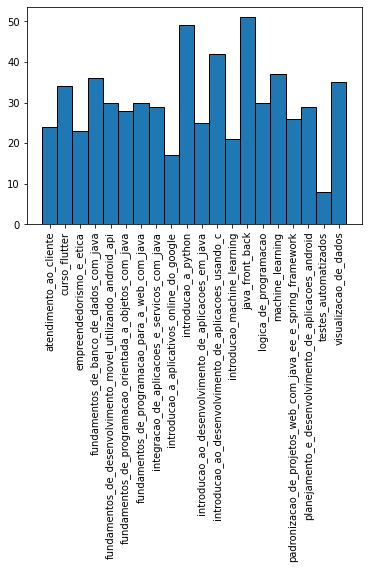

In [ ]:
u, c = np.unique(df['curso'].values.astype(str), return_counts=True)

plt.bar(u, c, width=1, edgecolor='k')
_ = plt.xticks(np.arange(len(u)), u, rotation=90)

In [ ]:
def normalize(text):
    # Passa os carácteres para minúsculo
    preprocessed = text.lower()
    # Remove acentos
    preprocessed = unidecode.unidecode(preprocessed)
    # Muda os separadores de sentença (não necessário)
    preprocessed = preprocessed.replace('. ', '[SEP]')
    preprocessed = preprocessed.replace('.', ' ')
    preprocessed = preprocessed.replace('[SEP]', '. ')
    preprocessed = preprocessed.replace('-', ' ')
    # Remove pontuação (a verificar para o caso de programação)
    preprocessed = preprocessed.translate(
        str.maketrans('', '', string.punctuation)
    )

    return preprocessed

In [ ]:
def normalize_token(text):
    # Remove espaços não necessários
    # e.g. "  eu" => "eu"
    return ' '.join(text.split())

In [ ]:
def tokenize(text, tokenizer):
    tokens = []
    for t in tokenizer(str(text)):
        tokens.append(normalize_token(str(t)))
    return tokens

In [ ]:
def create_vocab(texts, tokenizer):
    all_tokens = []
    for text in texts:
        # tokenize retorna uma lista de tokens
        tokens = tokenize(text, tokenizer)

        # OBS: tokens é uma lista
        all_tokens.extend(tokens)

    unique_tokens, counts = np.unique(all_tokens, return_counts=True)
    return {w: i for i, w in enumerate(unique_tokens)}, unique_tokens, counts

In [ ]:
df['normalized text'] = df['text'].astype(str).apply(normalize)

In [ ]:
df.head(5)

,id,text,curso,aula,normalized text
0,introducao_a_python-aula1.2-aba1.html,"Olá, seja bem-vindo(a). Neste curso, você vai...",introducao_a_python,aula1.2,ola seja bem vindoa neste curso voce vai conh...
2,fundamentos_de_programacao_para_a_web_com_java...,TÓPICO 2 –Criando o primeiro projeto web Obj...,fundamentos_de_programacao_para_a_web_com_java,aula01,topico 2 criando o primeiro projeto web obj...
3,fundamentos_de_programacao_orientada_a_objetos...,Tópico 1 – O que são Classes Abstratas. Obje...,fundamentos_de_programacao_orientada_a_objetos...,aula6,topico 1 o que sao classes abstratas objet...
4,planejamento_e_desenvolvimento_de_aplicacoes_a...,Tópico 4 – Navegando entre as telas da aplica...,planejamento_e_desenvolvimento_de_aplicacoes_a...,aula05,topico 4 navegando entre as telas da aplica...
5,integracao_de_aplicacoes_e_servicos_com_java-a...,TÓPICO 4 – Servidores de Aplicação Objetivos...,integracao_de_aplicacoes_e_servicos_com_java,aula05,topico 4 servidores de aplicacao objetivos...


In [ ]:
vocab, unique_tokens, counts = create_vocab(df['normalized text'].values.astype(str), tokenizer)

In [ ]:
unique_tokens = unique_tokens[counts.argsort()[::-1]]
counts = counts[counts.argsort()[::-1]]

In [ ]:
len(vocab)

24296

In [ ]:
df_tokens = pd.DataFrame()
df_tokens['token'] = unique_tokens
df_tokens['freq'] = counts

In [ ]:
df_tokens

,token,freq
0,de,46689
1,a,37772
2,o,34460
3,e,34180
4,que,25367
...,...,...
24291,habita,1
24292,habilitando,1
24293,h1produtosh1,1
24294,h1loja,1


## Atividade 23/12 - 30/12

* Passo 1: __normalizar__ a coluna de aula, no dataframe $df$. Normalizar nesse caso significa padronizar, por exemplo,

$$\text{aula1.2} => 1$$

* Passo 2: Extrair um vetor com o nome dos cursos de cada documento. 

* Passo 3: Predizer para cada pergunta no vetor $perguntas$, achar o índice $i$, que nos dá o documento mais similar. Nesse caso, o objeto $feature\_extractor$ irá transformar textos (ou documentos) em vetores. Assim,

$$q = feature\_extractor.transform(q\_text)$$

* Passo 4: Comparar acurácia por classe e acurácia média de cada modelo (TfIDF e CountVectorizer) com respeito aos cursos, e ao par (curso, aula).

In [ ]:
text_corpus = df['normalized text'].values.astype(str)

# Passo 1

* Passo 1: __normalizar__ a coluna de aula, no dataframe $df$. Normalizar nesse caso significa padronizar, por exemplo,

$$\text{aula1.2} => 1$$

In [ ]:
def normaliza_texto_aula(text):
    # Passa os carácteres para minúsculo
    preprocessed = text.lower()
    
    # remove o ponto e as informações seguintes
    point_idx = preprocessed.find('.')
    if point_idx != -1:
      preprocessed = preprocessed[:point_idx]

    # remove o dígito '0' da posição esquerda
    if preprocessed[4] == '0':
      preprocessed = preprocessed[:4] + preprocessed[5:]

    # aula
    # aula = float(preprocessed[4:])
    aula = int(preprocessed[4:])

    return aula

In [ ]:
# teste da função de normalização das aulas

normaliza_texto_aula('Aula4'), normaliza_texto_aula('Aula4.2'), normaliza_texto_aula('Aula 4.2')

(4, 4, 4)

In [ ]:
# criando uma coluna para os rotulos normalizados de aulas

df['aula normalizada'] = df['aula'].astype(str).apply(normaliza_texto_aula)
df['aula normalizada']

0      1
2      1
3      6
4      5
5      5
      ..
731    1
732    1
733    4
734    3
735    4
Name: aula normalizada, Length: 604, dtype: int64

# Passo 2

* Passo 2: Extrair um vetor com o nome dos cursos de cada documento. 

In [ ]:
# carregamento do conjunto de dados de testes

df_test = pd.read_csv(os.path.join(path, 'test_dataset.csv'))

In [ ]:
# normalização dos textos das perguntas e criação de coluna para as perguntas normalizadas

df_test['pergunta normalizada'] = df_test['Pergunta'].astype(str).apply(normalize)

In [ ]:
# extração dos vetores com os nomes dos cursos e aulas esperadas para cada pergunta

y_curso = df_test['Curso'].astype(str)
y_aula = df_test['Aula'].astype(int)

# Passos 3 e 4

* Passo 3: Predizer para cada pergunta no vetor $perguntas$, achar o índice $i$, que nos dá o documento mais similar. Nesse caso, o objeto $feature\_extractor$ irá transformar textos (ou documentos) em vetores. Assim,

$$q = feature\_extractor.transform(q\_text)$$

* Passo 4: Comparar acurácia por classe e acurácia média de cada modelo (TfIDF e CountVectorizer) com respeito aos cursos, e ao par (curso, aula).

## CountVectorizer

In [ ]:
# vetorização do conteúdo dos documentos utilizando o CountVectorizer
# a vetorização é armazenada na variável D

text_corpus = df['normalized text'].values.astype(str)
vectorizer = CountVectorizer(analyzer='word', vocabulary=vocab)
D = vectorizer.fit_transform(text_corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [ ]:
# vetorização do conteúdo das perguntas utilizando o CountVectorizer e o
# vocabulário criado anteriormente com os tokens dos documentos

# * assumi que todos os tokens presentes nas perguntas estão presentes nos documentos

# a vetorização é armazenada na variável Q

questions_corpus = df_test['pergunta normalizada'].values.astype(str)
Q = vectorizer.fit_transform(questions_corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [ ]:
# definição das funções de distância

from scipy.spatial import distance as sp_distance

def cos_distance(q, x):
  return sp_distance.cosine(q, x)

def euclid_distance(q, x):
  dist = np.linalg.norm(q - x)
  return dist

In [ ]:
# Para cada pergunta, encontra o documento com a menor distância

# distância euclidiana
def similar(Q, D):
  I_opt = []
  for q in Q:
    distancias = []
    for d in D:
      distancias.append(euclid_distance(q.toarray(), d.toarray()))
    i_opt = np.argmin(distancias)
    I_opt.append(i_opt)
  return I_opt

# distância cosseno
def similar_cos_distance(Q, D):
  I_opt = []
  for q in Q:
    distancias = []
    for d in D:
      distancias.append(cos_distance(q.toarray(), d.toarray()))
    i_opt = np.argmin(distancias)
    I_opt.append(i_opt)
  return I_opt

# execução
I_opt = similar_cos_distance(Q, D)

In [ ]:
y_curso_pred = []
y_aula_pred = []
for i in range(len(I_opt)):
  # I_opt[i] é o indice do curso predito, utilizando iloc devido aos indices
  # removidos
  curso_pred = df.iloc[[I_opt[i]]]['curso'].values.astype(str)[0]

  # verifica aula somente se acertou o curso
  if curso_pred == y_curso[i]:
    aula_pred = df.iloc[[I_opt[i]]]['aula normalizada'].values.astype(str)[0]
    aula_pred = int(aula_pred)
  else:
    aula_pred = -1

  y_curso_pred.append(curso_pred)
  y_aula_pred.append(int(aula_pred))

In [ ]:
# acurácia predicao curso
accuracy_score(y_curso, y_curso_pred)

0.4504950495049505

In [ ]:
# acurácia predicao aula e curso
accuracy_score(y_aula, y_aula_pred)

0.3217821782178218

In [ ]:
def extract_aula(txt):
    num = int(float(txt.split('aula')[1]))
    return num

retrieved_documents = df.iloc[I_opt, :]

predicted_course = retrieved_documents['curso'].values
predicted_aula = retrieved_documents['aula'].apply(extract_aula).values

ground_truth_course = df_test['Curso'].values.astype(str)
ground_truth_aula = df_test['Aula'].values.astype(int)

acc_course = 100 * sum(1. * (predicted_course == ground_truth_course)) / len(df_test)

acc_aula = 100 * sum(
    1 * np.logical_and(predicted_course == ground_truth_course, predicted_aula == ground_truth_aula)) / len(df_test)

print(acc_course, acc_aula)

45.04950495049505 32.17821782178218


In [ ]:
import sklearn.metrics

def my_accuracy_score(confusion_matrix, labels):

  total_correct = 0.0
  total_prediction = 0.0

  n_classes = len(confusion_matrix[0])
  for i in range(n_classes):
    correct_count = confusion_matrix[i][i]
    class_pred = sum(confusion_matrix[i])

    total_correct += correct_count
    total_prediction += class_pred
    
    accuracy = 100 * float(correct_count) / class_pred

    print(f'Acurácia para a classe {labels[i]}: {accuracy:.1f} %')
  print("Acurácia global {:.1f}%".format(100 * total_correct/total_prediction))

In [ ]:
labels_cursos = np.unique(df['curso'].values.astype(str))
labels_cursos = list(labels_cursos)

# matriz de confusao
cmat = sklearn.metrics.confusion_matrix(y_curso, y_curso_pred, labels=labels_cursos)

# acurácia por curso
my_accuracy_score(cmat, labels=labels_cursos);

Acurácia para a classe atendimento_ao_cliente: nan %
Acurácia para a classe curso_flutter: nan %
Acurácia para a classe empreendedorismo_e_etica: 50.0 %
Acurácia para a classe fundamentos_de_banco_de_dados_com_java: nan %
Acurácia para a classe fundamentos_de_desenvolvimento_movel_utilizando_android_api: nan %
Acurácia para a classe fundamentos_de_programacao_orientada_a_objetos_com_java: nan %
Acurácia para a classe fundamentos_de_programacao_para_a_web_com_java: nan %
Acurácia para a classe integracao_de_aplicacoes_e_servicos_com_java: nan %
Acurácia para a classe introducao_a_aplicativos_online_do_google: 20.0 %
Acurácia para a classe introducao_a_python: 92.9 %
Acurácia para a classe introducao_ao_desenvolvimento_de_aplicacoes_em_java: nan %
Acurácia para a classe introducao_ao_desenvolvimento_de_aplicacoes_usando_c: 43.3 %
Acurácia para a classe introducao_machine_learning: nan %
Acurácia para a classe java_front_back: 43.8 %
Acurácia para a classe logica_de_programacao: 50.0 %
Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


## TfidfVectorizer

In [ ]:
text_corpus = df['normalized text'].values.astype(str)
vectorizer = TfidfVectorizer(analyzer='word', vocabulary=vocab)
D = vectorizer.fit_transform(text_corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [ ]:
questions_corpus = df_test['pergunta normalizada'].values.astype(str)
Q = vectorizer.fit_transform(questions_corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [ ]:
I_opt = similar_cos_distance(Q, D)

In [ ]:
y_curso_pred = []
y_aula_pred = []
for i in range(len(I_opt)):
  # I_opt[i] é o indice do curso predito, utilizando iloc devido aos indices
  # removidos
  curso_pred = df.iloc[[I_opt[i]]]['curso'].values.astype(str)[0]

  # verifica aula somente se acertou o curso
  if curso_pred == y_curso[i]:
    aula_pred = df.iloc[[I_opt[i]]]['aula normalizada'].values.astype(str)[0]
    aula_pred = int(aula_pred)
  else:
    aula_pred = -1

  y_curso_pred.append(curso_pred)
  y_aula_pred.append(int(aula_pred))

In [ ]:
# acurácia predicao curso
accuracy_score(y_curso, y_curso_pred)

0.6485148514851485

In [ ]:
# acurácia predicao aula e curso
accuracy_score(y_aula, y_aula_pred)

0.5594059405940595

In [ ]:
labels_cursos = np.unique(df['curso'].values.astype(str))
labels_cursos = list(labels_cursos)

# matriz de confusao
cmat = sklearn.metrics.confusion_matrix(y_curso, y_curso_pred, labels=labels_cursos)

# acurácia por curso
my_accuracy_score(cmat, labels=labels_cursos);

Acurácia para a classe atendimento_ao_cliente: nan %
Acurácia para a classe curso_flutter: nan %
Acurácia para a classe empreendedorismo_e_etica: 70.0 %
Acurácia para a classe fundamentos_de_banco_de_dados_com_java: nan %
Acurácia para a classe fundamentos_de_desenvolvimento_movel_utilizando_android_api: nan %
Acurácia para a classe fundamentos_de_programacao_orientada_a_objetos_com_java: nan %
Acurácia para a classe fundamentos_de_programacao_para_a_web_com_java: nan %
Acurácia para a classe integracao_de_aplicacoes_e_servicos_com_java: nan %
Acurácia para a classe introducao_a_aplicativos_online_do_google: 90.0 %
Acurácia para a classe introducao_a_python: 92.9 %
Acurácia para a classe introducao_ao_desenvolvimento_de_aplicacoes_em_java: nan %
Acurácia para a classe introducao_ao_desenvolvimento_de_aplicacoes_usando_c: 60.0 %
Acurácia para a classe introducao_machine_learning: nan %
Acurácia para a classe java_front_back: 53.1 %
Acurácia para a classe logica_de_programacao: 64.3 %
Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
